In [1]:
import json
import os
import csv
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from typing import List
import matplotlib.pyplot as plt

NUM_WORDS = 5000
NUM_AUTHORS = 21246
MAX_LEN = 250
RANDOM_STATE = 42069

In [2]:
def load_data_set(path: str):
    """
    loads data set located at path and returns as pandas data frame
    """
    with open(path) as file:
        data = json.load(file)
    
    print(f"loaded {len(data)} instances")
    data = pd.json_normalize(data)
    return data

In [3]:
path = "train.json"
train = load_data_set(path)
train.head()

loaded 25793 instances


,authors,year,abstract,venue,title
0,"[42, 13720, 36]",9,"[2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...",20,"[41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1..."
1,"[1359, 15881, 45]",15,"[40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...",2,"[1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3..."
2,"[19166, 17763]",17,"[40, 1542, 1691, 2449, 1535, 2610, 1543, 1535,...",,"[2085, 1719, 1846, 1745, 2243, 1553, 1606, 159..."
3,[97],10,"[46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...",4,"[40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5..."
4,"[19617, 2]",10,"[37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...",9,"[38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,..."


## Preprocessing

In [4]:
def preprocess(df: pd.DataFrame, train=True, drop_samples=False):
    
    df = df.copy(deep=True)
   
    if train:
        df["target authors"] = df["authors"].apply(lambda x: filter_authors(x))
        df["coauthors"]      = df["authors"].apply(lambda x: filter_authors(x, prolifics=False))
        df = df.drop(["authors"], axis=1)
    
    # drops samples containing no prolific authors, Reduces training set by ~60% to 7000 samples
    if drop_samples:
        df["has target"] = df["target authors"].apply(lambda x: len(x)>0)
        df = df[df["has target"] == True]
        df = df.drop(["has target"], axis=1)
        
    # text transormation
    # we stringify the list of int's to be used as inputs to the TF-IDF vectoriser
    df["text"] = df["title"] + df["abstract"]
    df["str text"] = df["text"].apply(lambda xs: ''.join(str(x)+' ' for x in xs))
    
    # preprocessing for venue. We use minmax scaling as a matter of best-practice. 
    # as we require all rows to have integer values, we give blank venues a dummy value of 465
    scalar = MinMaxScaler()
    df.loc[df.venue == "", "venue"] = 465
    df["venue"] = scalar.fit_transform(df["venue"].to_numpy().reshape(-1, 1))

    # drop
    #df = df.drop(["abstract", "title", "year"], axis=1)
    df = df.drop(["abstract", "title"], axis=1)
    return df

In [5]:
def filter_authors(authors: List[int], prolifics=True):
    """
    filters authors between prolific and coauthors
    """
    if prolifics:
        prolifics = filter(lambda x: x < 100, authors)
        return list(prolifics)
    else:
        coauthors = filter(lambda x: x>=100, authors)
        return list(coauthors)

(array([ 123.,   89.,  128.,  177.,  214.,  220.,  254.,  266.,  396.,
         449.,  489.,  433.,  522.,  561.,  590.,  608., 1283.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 <BarContainer object of 17 artists>)

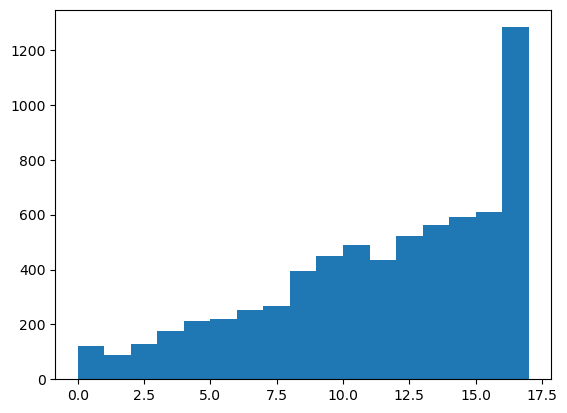

In [6]:
df = preprocess(train, train=True, drop_samples=True)
df.head()
plt.hist(df["year"], bins=np.arange(df["year"].min(), df["year"].max()))

In [7]:
df["year"].unique()

array([ 9, 15, 10, 18, 11,  8,  2, 13,  1, 16,  6,  5, 17, 14,  3, 12,  4,
        7,  0])

## TF-IDF Preprocessing

TF-IDF is a nlp preprocessing method to map text input to a vector of reals. TF-IDF is an improvement upon previous feature engineering that we have performed as it adjusts the value of each word, relative to how freuently it occurs. Stop words such as *the, it, how* have relatively low weightings, so the resulting vector only captures the most *important* words within the input. This (typically) leads to TF-IDF representations outperforming word-count representations for most tasks

We use `sklearn`'s feature extraction to automate this process. 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf   = TfidfVectorizer()
vectors = tfidf.fit_transform(df["str text"])

In [9]:
feature_names = tfidf.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()
df_text = pd.DataFrame(denselist, columns=feature_names)
df_text.head()

,10,100,1005,1006,1007,1009,101,1014,1016,1022,...,962,965,968,970,973,977,98,980,987,998
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.090374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.018773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.130861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_auth_venue = df[["target authors", "venue", "coauthors", "year"]]
df_full       = pd.concat([df_text.reset_index(drop=True), df_auth_venue.reset_index(drop=True)], axis=1)
df_full.head()

,10,100,1005,1006,1007,1009,101,1014,1016,1022,...,973,977,98,980,987,998,target authors,venue,coauthors,year
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[42, 36]",0.043011,[13720],9
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,[45],0.004301,"[1359, 15881]",15
2,0.090374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,[97],0.008602,[],10
3,0.018773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,[2],0.019355,[19617],10
4,0.130861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[44, 2]",0.000000,"[9641, 5623]",18


## Author Preprocessing

We previously used a binning strategy of dealing with coauthors. This time, we instead use a simple count of how many coauthors (with `id>100`) they have previously colaborated with appear in the paper. To do this, we build a dictionary of lists of coauthors for each prolific author.

In [11]:
def construct_collaborator_dictionary(df: pd.DataFrame):
    """
    Constructs a database of collobaroter for given author id key. 
    """
    
    collaboraters = {}
    authors       = np.arange(100)
    
    for author in authors:
        df_auth = df.copy(deep=True)
        df_auth["label"] = df_auth["target authors"].apply(lambda x: 1 if author in x else 0)
        df_auth = df_auth[df_auth["label"] == 1]
        coauths = list(set(df_auth["coauthors"].sum()))
        collaboraters[author] = coauths
    
    return collaboraters

In [12]:
collaborator_db = construct_collaborator_dictionary(df_full)

## Model Validation

We now build and validate a model. We use a `RANDOM_STATE` seed to ensure we generate the same training/evaluation split. We write our results to a csv file to avoid an unecessarily long notebook

In [13]:
def upsample_training(X_train, y_train):
    """
    upsamples the minority class until class balance is achieved
    """
    X = pd.concat([X_train, y_train], axis=1)
    
    
    pos = X[X["label"] == 1]
    neg = X[X["label"] == 0]
    
    pos_upsample = resample(pos, replace=True, n_samples=len(neg), random_state=RANDOM_STATE)
    
    resampled = pd.concat([neg, pos_upsample])

    y_train = resampled["label"]
    X_train = resampled.drop(["label"], axis=1)
    return X_train, y_train


def resample_training(X_train, y_train):
    """
    resamples class imbalance using SMOTE: 
    https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
    """
    sm = SMOTE(random_state=RANDOM_STATE)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train

In [14]:
def get_train_val_data(author: int, df:pd.DataFrame, restr = False):
    # take copy and prepare label
    df = df.copy(deep=True)
    df["label"] = df["target authors"].apply(lambda x: 1 if author in x else 0)
    
    # map number of collaborators for this given instance 
    collabs = collaborator_db[author]
    df["num collaborators"] = df["coauthors"].apply(lambda x: len(set(x).intersection(collabs)))
    
    # drop irrelevant columns
    if restr:
        df = df.drop(df[(df["year"] < 9) & (df["label"] == 1)].index)

    X = df.drop(["label", "target authors", "coauthors", "year"], axis=1)
    y = df["label"]

    #Based on the restr variable index based on year.
    #if restr:
    #    X = X.loc[X["year"] >= 9]

    #X = X.drop(["year"], axis=1)
    
    # split training and validation - we have fixed random state for reproducability
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    
    # upsample to deal with class imbalance
    X_train, y_train = upsample_training(X_train, y_train)
    
    # we convert to numpy arrays for fitting to sklearn models
    # the reason for this is that sklearn throws annoying warnings otherwise
    return np.array(X_train), np.array(X_val), np.array(y_train), np.array(y_val)

In [15]:
def validate_to_csv(df: pd.DataFrame, restr_lst):
    """
    As we are building 100 classifiers, printing f1 scores within a notebook is impractical. 
    following function writes results to csv. 
    """
    author_lst = []
    with open("validation_restr_year.csv", mode='w') as f:    
        writer = csv.writer(f)
        
        header = ['Author Id','F1 score']
        writer.writerow(header)
        
        # loop over each author, build classifier and write to output
        authors = np.arange(100)
        
        avg = 0
        for author in tqdm(authors):

            if author in restr_lst:
                X_train, X_val, y_train, y_val = get_train_val_data(author, df, True)
            elif author not in restr_lst:
                X_train, X_val, y_train, y_val = get_train_val_data(author, df, False)
            
            clf = LogisticRegression()
            clf.fit(X_train, y_train)
            
            y_pred = clf.predict(X_val)
            
            f1 = f1_score(y_pred, y_val)
            avg += f1
            writer.writerow([author, f1])
            if f1 <= 0.5:
                author_lst.append((f1, author))
        writer.writerow(["average", avg])
    author_lst.sort()
    return author_lst

In [16]:
#plt.hist(df_full["year"], bins=np.arange(df["year"].min(), df["year"].max()))
df_full.head()

,10,100,1005,1006,1007,1009,101,1014,1016,1022,...,973,977,98,980,987,998,target authors,venue,coauthors,year
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[42, 36]",0.043011,[13720],9
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,[45],0.004301,"[1359, 15881]",15
2,0.090374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,[97],0.008602,[],10
3,0.018773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,[2],0.019355,[19617],10
4,0.130861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[44, 2]",0.000000,"[9641, 5623]",18


In [17]:
def print_function(author, df):
    #for item in author_lst:
    # take copy and prepare label
    df = df.copy(deep=True)
    df["label"] = df["target authors"].apply(lambda x: 1 if author in x else 0)
    df_val = df[(df["label"] == 1)] 
    df_plot = df[(df["label"] == 1) & (df["year"] >= 9)] 
    print("length", len(df_plot))
    print("length val", len(df_val))
    #Then plot based on those the author is in
    plt.hist(df_val["year"], bins=np.arange(df_val["year"].min(), df_val["year"].max()))
    #plt.hist(df_plot["year"], bins=np.arange(df_plot["year"].min(), df_plot["year"].max()))
    return

restr_lst = [71, 18, 28, 86, 62, 3, 81, 51, 34, 6, 20, 99] 

In [18]:
#print_function(restr_lst[0], df_full) 

In [19]:
result = validate_to_csv(df_full, restr_lst)
#print(result)
#[(0.3333333333333333, 71), (0.34782608695652173, 18), (0.3529411764705882, 28), 
# (0.3529411764705882, 86), (0.3555555555555555, 62), (0.3846153846153846, 3), 
# (0.4, 81), (0.4761904761904762, 51), (0.48484848484848486, 34), (0.5, 6), (0.5, 20), (0.5, 99)]

100%|██████████| 100/100 [08:24<00:00,  5.05s/it]


In [20]:
#Author ID 71:
#This is a test:


## Build Binary Classifiers

We now build the 100 binary classifers, one for each author

In [21]:
models = []
authors = np.arange(100)

for author in tqdm(authors):
    X_train, X_val, y_train, y_val = get_train_val_data(author, df_full)#, split=0.1)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    models.append(clf)

 58%|█████▊    | 58/100 [04:50<03:47,  5.42s/it]

## Build Predictions

We now load in our `test.json` set to generate predictions. We first put the training data through the usual preprocessing pipeline and exclude vocabular that was not part of our `tf-idf` training lexicon

In [ ]:
path = "test.json"
df_test = load_data_set(path)
df_test = preprocess(df_test, train=False)
df_test.head()

In [ ]:
df_test

In [ ]:
# this complicated looking lambda simply removes any words that were not part of our preprocessing. 
# failing to do so, would pass an unseen word to our tf-idf vectoriser and would crash our program
tfidf_features  = tfidf.get_feature_names_out()
df_test['text'] = df_test['text'].apply(lambda xs: list(filter((lambda x: str(x) in tfidf_features), xs)))
df_test["text"] = df_test["text"].apply(lambda xs: ''.join(str(x)+' ' for x in xs))

In [ ]:
# now apply the tf-idf transformation to the text component
X_test = tfidf.transform(df_test['text'])
X_test = pd.DataFrame((X_test.todense().tolist()), columns=tfidf_features)

In [ ]:
# now put everything back together
test = pd.concat([X_test, df_test["venue"], df_test["coauthors"], df_test["year"]], axis=1)
plt.hist(test["year"], bins=np.arange(test["year"].min(), test["year"].max()))
#test = test.drop(["year"], axis=1)

In [ ]:
#test["year"]

0      19
1      19
2      19
3      19
4      19
       ..
795    19
796    19
797    19
798    19
799    19
Name: year, Length: 800, dtype: int64

[19]


(array([  0.,   0.,   0.,   0.,   0., 800.,   0.,   0.,   0.,   0.]),
 array([18.5, 18.6, 18.7, 18.8, 18.9, 19. , 19.1, 19.2, 19.3, 19.4, 19.5]),
 <BarContainer object of 10 artists>)

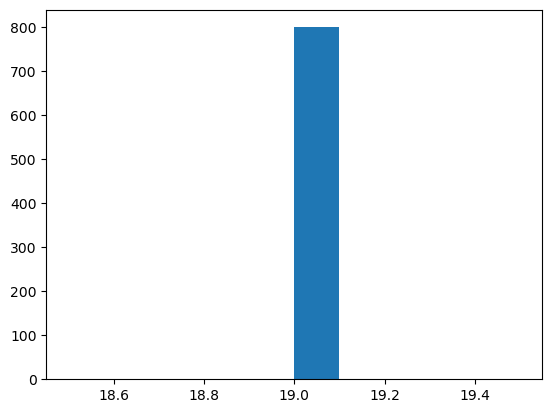

In [ ]:
print(test["year"].unique())
#Just the year 19!
plt.hist(test["year"])

In [ ]:
def make_predictions(test_df: pd.DataFrame):
    """
    function for writing predictions to output file. 
    WARNING: Deletes predictions.csv if present in working directory
    """
    if os.path.exists("predictions_restr_year.csv"):
        os.remove("predictions_restr_year.csv")
        print("removed previous predictions")
    
    
    with open("predictions_restr_year.csv", mode='w') as f:    
        writer = csv.writer(f)
        
        header = ['Id','Predict']
        writer.writerow(header)
        n      = X_test.shape[0]
        
        # loop over each training sample and write to necessary format
        for Id in tqdm(range(n)):
            
            # we need to keep x as a dataframe for this model so we can apply the collobartor mapping easily
            x   = test_df.iloc[Id].to_frame().T
            row = [Id]
            authors = ""
            
            for author, model in enumerate(models):
                # map number of collaborators for this given instance 
                X = x.copy(deep = True)
                collabs = collaborator_db[author]
                X["num collaborators"] = X["coauthors"].apply(lambda x: len(set(x).intersection(collabs)))
                X = X.drop(["coauthors"], axis=1)
                X = np.array(X).reshape(1, -1)
               
                if np.array(model.predict(X)).item() == 1:
                    authors += str(author) + " "

            # to match the output requirement 
            if len(authors) == 0: row = [Id, -1]
            else: row = [Id, authors]
            
            writer.writerow(row)
    return

In [ ]:

test = test.drop(["year"], axis=1)
make_predictions(test)


  0%|          | 0/800 [00:00<?, ?it/s]

removed previous predictions


100%|██████████| 800/800 [03:45<00:00,  3.55it/s]
